# Hindi2Vec Language Modeling

The goal of this notebook is to train Hindi word embeddings using the [fast.ai](http://www.fast.ai/) version of [AWD LSTM Language Model](https://arxiv.org/abs/1708.02182)--basically LSTM with dropouts--with data from [Wikipedia](https://dumps.wikimedia.org/hiwiki/latest/hiwiki-latest-pages-articles.xml.bz2) (pulled on March 2, 2018). 

We achieved perplexity of 46.81, compared to [state-of-the-art on November 17, 2017](https://github.com/RedditSota/state-of-the-art-result-for-machine-learning-problems) at 40.68 for English language. To the best of our knowledge, there is no comparable research in Hindi language at the point of writing (March 2, 2018).

## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import dill as pickle
import json
from IPython.display import Image
from IPython.core.display import HTML

from spacy.lang.hi import *

import re
import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

In [2]:
from fastai.learner import *
from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

In [3]:
PATH='C:\\Users\\nirantk\\Desktop\\hindi-wiki\\'
# path to the xml wikipedia dump

EXT_PATH = 'extract\\'
TRN_PATH = 'train\\'
VAL_PATH = 'valid\\'
SAMPLE_PATH = 'sample\\'

EXT = f'{PATH}{EXT_PATH}'
TRN = f'{PATH}{TRN_PATH}'
VAL = f'{PATH}{VAL_PATH}'
SAMPLE = f'{PATH}{SAMPLE_PATH}'

ext_files = !ls {EXT}
sample_files = !ls {SAMPLE}

## Text Cleaning

In [4]:
# Exact command line statement used to extract content from xml file
# !python wikiextractor/WikiExtractor.py hiwiki-latest-pages-articles.xml -o extract -b 10M --ignored_tags abbr,b,big --discard_elements gallery,timeline,noinclude

### Save as Plain Text

In [ ]:
%%time
%%prun


def clean_files(extracted_filelist, TRN):    
    cleaned_all = []
    for ext_file in extracted_filelist:
        input_file = f'{EXT}{ext_file}'
        with open(input_file,'r', encoding='utf-8') as f:
            raw_txt = f.readlines()
            cleaned_doc = []
            for line in raw_txt:
                new_line = re.sub('<[^<]+?>', '', line)
                new_line = re.sub('__[^<]+?__', '', new_line) 
                new_line = new_line.strip()
                if new_line != '':
                    cleaned_doc.append(new_line)

            new_doc = "\n".join(cleaned_doc)
            cleaned_all.append(new_doc)
            with open(f"{TRN}{ext_file}.txt", "w", encoding='utf-8') as text_file:
                text_file.write(new_doc)
    return cleaned_all

cleaned_all = clean_files(ext_files, TRN)

In [ ]:
print(f'Preview:\n{cleaned_all[0][:500]}\n\nLength of list (should be equal to number of documents): {len(cleaned_all)}')

### Create Validation Set

In [ ]:
import random

random.shuffle(trn_files)
len_valid = int(0.2 * len(trn_files)) 
val_files = trn_files[:len_valid]
trn_files = trn_files[len_valid:]

In [ ]:
# # WARNING: Run exactly ONCE

# import shutil, os
# for root, dirs, files in os.walk(TRN):
#     for file in files:
#         if file.endswith(".txt") & (file in val_files):
#             shutil.move(os.path.join(root, file),VAL)

In [5]:
trn_files = !ls {TRN}
val_files = !ls {VAL}
print(trn_files), print(val_files), print(len(trn_files)), print(len(val_files))

['wiki_00.txt', 'wiki_01.txt', 'wiki_04.txt', 'wiki_05.txt', 'wiki_06.txt', 'wiki_07.txt', 'wiki_08.txt', 'wiki_11.txt', 'wiki_12.txt', 'wiki_13.txt', 'wiki_14.txt', 'wiki_15.txt', 'wiki_16.txt', 'wiki_17.txt', 'wiki_19.txt', 'wiki_20.txt', 'wiki_21.txt', 'wiki_22.txt', 'wiki_24.txt', 'wiki_25.txt', 'wiki_26.txt', 'wiki_28.txt', 'wiki_29.txt', 'wiki_30.txt', 'wiki_31.txt', 'wiki_32.txt', 'wiki_33.txt', 'wiki_34.txt', 'wiki_35.txt', 'wiki_36.txt']
['wiki_02.txt', 'wiki_03.txt', 'wiki_10.txt', 'wiki_23.txt']
30
4


(None, None, None, None)

## Text Processing

### Tokenizer

In [6]:
def word_tokenize(document):
    nlp = Hindi() # from spacy.lang.hi
    return [token.text for token in nlp(document)]
    
def docs_tokenize(documents_as_lists):   
    for document in documents_as_lists:
        tokens = word_tokenize(document)
        tokens_list.extend(tokens)
    
    return tokens_list

In [7]:
%%time
tokens_filename = "tokens_list.txt"
tokens_list = []

#TODO refactor from try except blocks to if else with if statement checking if file exists using Pathlib

try:
    print(f'Reading from {tokens_filename}')
    with open(tokens_filename, "r") as f:
         tokens_list = json.load(f)
    
except FileNotFoundError:
    print(f'FileNotFound. Trying to tokenize from cleaned_all')
    tokens_list = docs_tokenize(cleaned_all)
    
    with open('tokens_list.txt', 'w') as outfile:
        json.dump(tokens_list, outfile)

print(f'Found {len(tokens_list)} tokens') # 30598557 tokens expected

Reading from tokens_list.txt
Found 30598557 tokens
Wall time: 16 s


### Min Count

In [ ]:
# TEXT = pickle.load(open(f'{PATH}models/TEXT.pkl','rb'))
# freqs = pd.DataFrame.from_dict(TEXT.vocab.freqs,orient='index')
# freqs.sort_values(0,ascending=False).head(10)

In [ ]:
# cnt = []
# for i in range(49):
#     row_cnt = freqs[freqs[0]>=i+1].shape[0]
#     cnt.append(row_cnt)

In [ ]:
# plt.plot(cnt)
# plt.axvline(x=10,color='red', linestyle='--')

In [ ]:
# #number of legitimate thai words at freqs
# freqs[freqs[0]<=10].sort_values(ascending=False,by=0).head(10)

### Data Loader

In [8]:
assert torch.cuda.is_available()
assert torch.backends.cudnn.enabled

In [9]:
TEXT = data.Field(lower=True, tokenize=word_tokenize)
#batch size
bs=16
#backprop through time
bptt=70

In [10]:
#FILES = dict(train=f'{SAMPLE_PATH}', validation=f'{SAMPLE_PATH}', test=f'{SAMPLE_PATH}')
FILES = dict(train=f'{TRN_PATH}', validation=f'{VAL_PATH}', test=f'{SAMPLE_PATH}')

In [11]:
%%time
md = LanguageModelData.from_text_files(PATH, TEXT, **FILES, bs=bs, bptt=bptt, min_freq=50)

Wall time: 21min 20s


In [12]:
%%time
pickle.dump(TEXT, open(f'{PATH}//models//TEXT_min_freq50.pkl','wb'))

Wall time: 751 ms


In [26]:
len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(21791, 21821, 1, 24407648)

In [27]:
TEXT.vocab.itos[:12]

['<unk>', '<pad>', 'के', '।', ',', 'में', 'है', 'की', 'और', 'से', 'का', 'को']

In [31]:
TEXT.vocab.stoi['सभी']

123

In [32]:
md.trn_ds[0].text[:12]

['हम',
 'होंगे',
 'कामयाब',
 'दैनिक',
 'पूजा',
 'दैनिक',
 'पूजा',
 'विधि',
 'हिन्दू',
 'धर्म',
 'की',
 'कई']

In [33]:
next(iter(md.trn_dl))

(Variable containing:
    430      3   2017  ...     997    607    745
   1862    990   2414  ...       2      4      2
   4871      0    343  ...    2576    540    163
         ...            ⋱           ...         
      0      5     23  ...       8    540      4
      4      0      3  ...      81      4    415
    648      0   7395  ...    1472     88    281
 [torch.cuda.LongTensor of size 69x16 (GPU 0)], Variable containing:
   1862
    990
   2414
   ⋮   
   6439
     90
     12
 [torch.cuda.LongTensor of size 1104 (GPU 0)])

In [13]:
#trn_ds is list; one for each txt file
txt = md.trn_ds[0].text[:10]
TEXT.numericalize([txt])

Variable containing:
  430
 1862
 4871
 1559
 1007
 1559
 1007
  565
  589
  202
[torch.cuda.LongTensor of size 10x1 (GPU 0)]

## Language Model

### Training

In [14]:
em_sz = 300  # size of each embedding vector
nh = 500     # number of hidden activations per layer
nl = 3       # number of layers

In [15]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [16]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
               dropouti=0.05, dropout=0.05, wdrop=0.1, dropoute=0.02, dropouth=0.05)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 76%|█████████████████████████████████████████████████▌               | 16635/21791 [20:59<06:30, 13.21it/s, loss=18.8]

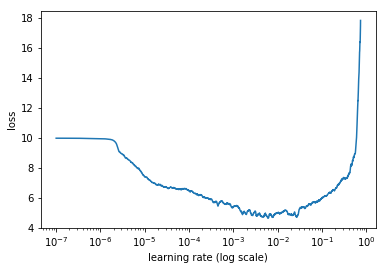

 76%|█████████████████████████████████████████████████▌               | 16635/21791 [21:10<06:33, 13.10it/s, loss=18.8]

In [17]:
#find suitable learning rates
learner.lr_find(1e-07,1e2)
learner.sched.plot()

In [ ]:
learner.fit(1e-4, 4, wds=1e-6, cycle_len=1, cycle_mult=2)
learner.save_encoder('adam1_enc')

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

  0%|                                                                    | 12/21791 [00:00<29:47, 12.19it/s, loss=9.99]


Exception in thread Thread-12:
Traceback (most recent call last):
  File "C:\Users\nirantk\Anaconda3\envs\fastai\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\nirantk\Anaconda3\envs\fastai\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\nirantk\Anaconda3\envs\fastai\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                                                                                         
    0      5.371777   5.243932  
    1      4.339965   4.741244                                                                                         
    2      4.437619   4.622295                                                                                         
    3      4.05479    4.533704                                                                                         
    4      4.007942   4.438206                                                                                         
    5      3.997428   4.379419                                                                                         
    6      4.074864   4.318187                                                                                         
    7      3.923672   4.335486                                                                                         
    8  

In [19]:
learner.save_encoder('adam1_enc')

In [23]:
#loss 3.84171; perplexity 46.61
learner.fit(1e-3, 1, wds=1e-6, cycle_len=20, cycle_save_name='adam3_20')
#learner.save_encoder('adam3_enc')

In [22]:
learner.save_encoder('adam3_hindi_minfreq10_enc_v2')

In [24]:
learner.fit(1e-3, 1, wds=1e-6, cycle_len=5, cycle_save_name='adam3_20')

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                                                                                         
    0      3.50012    4.0503    
    1      3.489653   4.020124                                                                                         
    2      3.498954   3.959882                                                                                         
    3      3.501738   3.891938                                                                                         
    4      3.602018   3.846254                                                                                         



[3.846254]

In [25]:
learner.save_encoder('adam3_20')

# Testing Results

In [40]:
m=learner.model
ss="""सीआईडी सोनी चैनल पर प्रसारित होने वाला हिन्दी भाषा का एक धारावाहिक है, जिसे भारत का सबसे लंबा चलने वाला धारावाहिक होने का श्रेय प्राप्त है। अपराध व जासूसी शैली पर आधारित इस धारावाहिक में शिवाजी साटम, दयानन्द शेट्टी और आदित्य श्रीवास्तव मुख्य किरदार निभा रहे हैं। इसके सर्जक, निर्देशक और लेखक बृजेन्द्र पाल सिंह हैं। इसका निर्माण फायरवर्क्स नामक कंपनी ने किया है जिसके संस्थापक बृजेन्द्र पाल सिंह और प्रदीप उपूर हैं। 21 जनवरी 1998 से शुरु होकर यह धारावाहिक अब तक लगातार चल रहा है। इसका प्रसारण प्रत्येक शनिवार और रविवार को रात 10 बजे होता है। इसका पुनः प्रसारण सोनी पल चैनल पर रात 9 बजे होता है जिसमें इसके पुराने प्रकरण दिखाये जाते हैं। इस धारावाहिक ने 21 जनवरी 2018 को अपने प्रसारण के 20 वर्ष पूर्ण किये और 21वें वर्ष में प्रवेश किया। इससे पहले, 27 सितम्बर 2013 को इस धारावाहिक ने अपनी 1000वीं कड़ी पूरी की। """
s = [spacy_tok(ss)]
t=TEXT.numericalize(s)
' '.join(s[0])

'सीआईडी सोनी चैनल पर प्रसारित होने वाला हिन्दी भाषा का एक धारावाहिक है , जिसे भारत का सबसे लंबा चलने वाला धारावाहिक होने का श्रेय प्राप्त है । अपराध व जासूसी शैली पर आधारित इस धारावाहिक में शिवाजी साटम , दयानन्द शेट्टी और आदित्य श्रीवास्तव मुख्य किरदार निभा रहे हैं । इसके सर्जक , निर्देशक और लेखक बृजेन्द्र पाल सिंह हैं । इसका निर्माण फायरवर्क्स नामक कंपनी ने किया है जिसके संस्थापक बृजेन्द्र पाल सिंह और प्रदीप उपूर हैं । 21 जनवरी 1998 से शुरु होकर यह धारावाहिक अब तक लगातार चल रहा है । इसका प्रसारण प्रत्येक शनिवार और रविवार को रात 10 बजे होता है । इसका पुनः प्रसारण सोनी पल चैनल पर रात 9 बजे होता है जिसमें इसके पुराने प्रकरण दिखाये जाते हैं । इस धारावाहिक ने 21 जनवरी 2018 को अपने प्रसारण के 20 वर्ष पूर्ण किये और 21वें वर्ष में प्रवेश किया । इससे पहले , 27 सितम्बर 2013 को इस धारावाहिक ने अपनी 1000वीं कड़ी पूरी की ।'

In [41]:
t

Variable containing:
 10984
  3460
  1517
    17
  1687
    75
   224
   195
   118
    10
    12
  1518
     6
     4
   178
    42
    10
    84
  2496
  1390
   224
  1518
    75
    10
  2127
   110
     6
     3
  1493
   128
  7799
   504
    17
   340
    24
  1518
     5
  4312
     0
     4
  9587
  9818
     8
  5518
  8218
   159
  1436
  5021
   109
    16
     3
    54
     0
     4
  1340
     8
   625
     0
  3573
   206
    16
     3
   119
   158
     0
   228
   305
    20
    18
     6
   215
  1681
     0
  3573
   206
     8
  7810
     0
    16
     3
  1067
   413
  1293
     9
   536
   363
    22
  1518
   183
    47
   969
   857
   120
     6
     3
   119
  1313
   274
  5463
     8
  4219
    11
   966
   389
  1743
    46
     6
     3
   119
   834
  1313
  3460
  7139
  1517
    17
   966
   498
  1743
    46
     6
   135
    54
   390
  3072
 14479
   138
    16
     3
    24
  1518
    20
  1067
   413
  5629
    11
    48
  1313
     2
   528
    55

In [46]:
# Set batch size to 1
m[0].bs=1
# Turn off dropout
m.eval()
# Reset hidden state
m.reset()
# Get predictions from model
res, *other_things = m(t)
# Put the batch size back to what it was
m[0].bs=bs

In [47]:
other_things

[[Variable containing:
  ( 0 ,.,.) = 
    5.6415e-03 -7.1320e-02 -2.2373e-02  ...  -4.2131e-01 -8.0832e-02  1.7624e-02
  
  ( 1 ,.,.) = 
    6.4953e-03  1.9529e-02  4.1037e-01  ...   6.1077e-02 -3.3719e-02  1.2098e-02
  
  ( 2 ,.,.) = 
    5.4429e-03  6.8038e-02 -4.6050e-01  ...  -6.6798e-04 -1.9427e-01 -6.1399e-03
  ... 
  
  (162,.,.) = 
   -1.1956e-01 -4.1483e-01 -2.1589e-01  ...  -3.5744e-01  7.1733e-01  7.3748e-02
  
  (163,.,.) = 
   -2.0688e-01  6.6090e-01 -6.5121e-03  ...  -7.7238e-01  1.1244e-02  5.3727e-03
  
  (164,.,.) = 
   -2.9987e-01 -3.7307e-02 -4.7536e-03  ...   1.2151e-01  1.4413e-02  2.9323e-02
  [torch.cuda.FloatTensor of size 165x1x500 (GPU 0)], Variable containing:
  ( 0 ,.,.) = 
   -1.1753e-02  3.5966e-02  5.9837e-03  ...   5.3034e-02  4.6100e-03 -3.9832e-02
  
  ( 1 ,.,.) = 
   -1.8573e-02  5.4061e-02 -1.3606e-02  ...  -1.8617e-01  3.7597e-03 -2.9424e-02
  
  ( 2 ,.,.) = 
   -1.9215e-02  1.1223e-01 -1.0460e-02  ...  -8.1387e-02  1.6686e-02  1.5788e-01
  ... 
  


In [43]:
nexts = torch.topk(res[-1], 10)[1]
[TEXT.vocab.itos[o] for o in to_np(nexts)]

['<unk>', 'यह', 'इस', 'इसके', 'इसका', 'इसमें', 'इसकी', 'इसे', 'फ़िल्म', 'बाद']

In [44]:
print(ss,"\n")
for i in range(100):
    n=res[-1].topk(2)[1]
    n = n[1] if n.data[0]==0 else n[0]
    print(TEXT.vocab.itos[n.data[0]], end=' ')
    res,*_ = m(n[0].unsqueeze(0))
print('...')

सीआईडी सोनी चैनल पर प्रसारित होने वाला हिन्दी भाषा का एक धारावाहिक है, जिसे भारत का सबसे लंबा चलने वाला धारावाहिक होने का श्रेय प्राप्त है। अपराध व जासूसी शैली पर आधारित इस धारावाहिक में शिवाजी साटम, दयानन्द शेट्टी और आदित्य श्रीवास्तव मुख्य किरदार निभा रहे हैं। इसके सर्जक, निर्देशक और लेखक बृजेन्द्र पाल सिंह हैं। इसका निर्माण फायरवर्क्स नामक कंपनी ने किया है जिसके संस्थापक बृजेन्द्र पाल सिंह और प्रदीप उपूर हैं। 21 जनवरी 1998 से शुरु होकर यह धारावाहिक अब तक लगातार चल रहा है। इसका प्रसारण प्रत्येक शनिवार और रविवार को रात 10 बजे होता है। इसका पुनः प्रसारण सोनी पल चैनल पर रात 9 बजे होता है जिसमें इसके पुराने प्रकरण दिखाये जाते हैं। इस धारावाहिक ने 21 जनवरी 2018 को अपने प्रसारण के 20 वर्ष पूर्ण किये और 21वें वर्ष में प्रवेश किया। इससे पहले, 27 सितम्बर 2013 को इस धारावाहिक ने अपनी 1000वीं कड़ी पूरी की।  

यह एक ऐसा व्यक्ति है जो अपने आप को एक दूसरे से अलग करता है । यह एक ऐसा व्यक्ति है जो अपने आप को एक दूसरे से अलग करता है । यह एक ऐसा व्यक्ति है जो अपने आप को एक दूसरे से अलग करता है । यह एक

In [ ]:
#m = learner.model
#pickle.dump(m,open(f'{PATH}models/wiki_lang.pkl','wb'))
TEXT = pickle.load(open(f'{PATH}models/TEXT.pkl','rb'))
m = pickle.load(open(f'{PATH}models/wiki_lang.pkl','rb'))
m[0].bs=1
m.eval()

In [ ]:
def gen_text(ss,topk):
    s = [word_tokenize(ss)]
    t = TEXT.numericalize(s)
    m.reset()
    pred,*_ = m(t)
    pred_i = torch.topk(pred[-1], topk)[1]
    return [TEXT.vocab.itos[o] for o in to_np(pred_i)]

def gen_sentences(ss,nb_words):
    result = []
    s = [word_tokenize(ss)]
    t = TEXT.numericalize(s)
    m.reset()
    pred,*_ = m(t)
    for i in range(nb_words):
        pred_i = pred[-1].topk(2)[1]
        pred_i = pred_i[1] if pred_i.data[0] < 2 else pred_i[0]
        result.append(TEXT.vocab.itos[pred_i.data[0]])
        pred,*_ = m(pred_i[0].unsqueeze(0))
    return(result)

In [ ]:
ss="""สวัสดีครับพี่น้องเสื้อ"""
gen_text(ss,10)

In [ ]:
''.join(gen_sentences(ss,50))

## Embeddings

### Extract

In [48]:
emb_weights = list(learner.model.named_parameters())[0][1]
emb_np = to_np(emb_weights.data)

In [49]:
emb_np.shape

(21821, 300)

In [51]:
TEXT = pickle.load(open(f'{PATH}//models//TEXT_min_freq50.pkl','rb'))

In [53]:
TEXT.vocab.set_vectors(vectors=emb_weights.data,dim=300,stoi=TEXT.vocab.stoi)
# pickle.dump(TEXT, open(f'{PATH}models/TEXT_vec.pkl','wb'))

In [54]:
TEXT_vec = pickle.load(open(f'{PATH}models/TEXT_vec.pkl','rb'))

In [55]:
hindi2vec = pd.DataFrame(to_np(TEXT_vec.vocab.vectors))
hindi2vec.index = TEXT_vec.vocab.itos
hindi2vec.head(10)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
<unk>,-0.025666,0.190339,-0.278813,-0.319441,-0.043037,0.034123,-0.271900,-0.014982,0.241724,-1.362962,...,-0.105750,0.000138,0.252063,0.322336,-0.234095,-0.076334,-0.357609,-0.376448,0.016019,-0.099436
<pad>,-0.125531,-0.153369,-0.190939,-0.342988,0.054864,-0.053099,0.114129,0.146933,-0.150632,0.331193,...,0.010165,0.212148,-0.309134,-0.256550,0.050639,0.086903,0.069713,0.099145,-0.143334,0.060667
के,-0.124854,-0.068364,-0.364002,-0.383810,0.172778,-0.003992,-0.168285,0.075885,-0.030859,-2.595019,...,-0.032839,0.077952,0.063838,0.858946,-0.325743,0.632531,-0.839241,-0.341894,-0.058192,-0.158500
।,-0.150303,-0.221962,-0.626972,-0.456973,0.470308,-0.213924,-0.112261,-0.437237,0.708551,3.330899,...,-0.472635,0.085662,-0.071612,-1.019616,-0.371203,-0.139772,-1.050309,-0.382592,-0.067022,-0.025990
",",-0.160962,-0.361875,-0.190295,-0.389795,0.216144,-0.050485,-0.192041,-2.112090,-0.685204,4.356941,...,-0.240056,-0.039866,-0.316080,0.169702,-0.359465,-0.325764,-0.872892,-0.408702,-0.118085,-0.199788
में,-0.209305,0.087706,-0.289885,-0.381661,0.208492,-0.069959,-0.083901,1.090752,-0.049023,2.092380,...,-0.080802,0.119540,-0.651442,0.565120,-0.270207,0.440532,-0.828658,-0.318647,-0.055147,-0.139348
है,-0.163855,0.305773,-0.496239,-0.385285,-0.023947,-0.196321,-0.206529,0.549503,0.392630,1.914814,...,-0.138870,0.029760,-0.292541,-1.653055,-0.312935,0.663974,-0.684114,-0.543373,0.049822,-0.194706
की,-0.179126,-0.189791,-0.428677,-0.418656,0.017380,-0.009977,-0.137235,0.626785,0.379204,-0.712076,...,-0.199796,0.077377,-0.134444,0.530944,-0.384973,-0.683671,-0.876726,-0.259445,-0.011620,-0.162889
और,-0.129317,-0.197093,-0.321741,-0.402978,0.194263,-0.088978,-0.178371,1.334814,-0.463591,-1.078326,...,-0.347151,-0.018696,-0.109680,0.606728,-0.374177,-0.089182,-0.906496,-0.386876,-0.097840,-0.239605
से,-0.204383,0.001643,-0.448961,-0.339362,-0.116989,-0.131715,-0.173486,-0.483954,-0.084200,-0.646569,...,-0.130293,0.198819,-1.254919,0.746580,-0.378496,0.199947,0.131102,-0.393537,-0.015223,-0.101342


In [56]:
hindi2save = hindi2vec[~hindi2vec.index.str.contains(' ')]
#remove lines with weird characters due to bad segmentation
# thai2save = thai2save.iloc[3:-48,:]
hindi2save.to_csv(f'{PATH}models//hindi2vec.vec',sep=' ',header=False, line_terminator='\n')
#add NB_ROWS NB_COLS as header
hindi2save.shape

(21816, 300)

In [ ]:
#TODO Convert hindivectors to gensim word2vec format

In [57]:
model.save_word2vec_format(f'{PATH}models/hindi2vec.vec',f'{PATH}models/hindi2vec.vocab',False)

NameError: name 'model' is not defined